In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate

In [13]:
from pynq import PL
PL.reset() #important fixes caching issues which have popped up.
from pynq import Overlay  #import the overlay module
ol = Overlay('./design_1.bit')  #locate/point to the bit file

In [14]:
# import pprint
# pprint.pprint(ol.ip_dict)

In [15]:
from pynq import Clocks
Clocks.pl_clk0_mhz = 150
print(Clocks.pl_clk0_mhz)

150


In [16]:
N = 8192
num_width = 32

In [6]:
def get_twos_from_decimal(decimal, num_bits):
    decimal = int(decimal)
    return decimal % (1<<num_bits)

In [7]:
def get_value_from_complex(real, imag, num_bits):
    return get_twos_from_decimal(real, num_bits)*(1<<num_bits)+get_twos_from_decimal(imag, num_bits)

In [8]:
def get_decimal_from_twos(twos, num_bits):
    twos = int(twos)
    if twos >= (1<<(num_bits-1)):
        return twos - (1<<num_bits)
    else:
        return twos

In [9]:
def get_components(complex_array):
    return {
        'real': np.array([get_decimal_from_twos(x // (1<<(num_width//2)), (num_width//2)) for x in complex_array]),
        'imag': np.array([get_decimal_from_twos(x % (1<<(num_width//2)), (num_width//2)) for x in complex_array])
    }

In [22]:
dma_0 = ol.axi_dma_0

In [19]:
iq_data = allocate(N, dtype=np.uint32)
for i in range(N):
    iq_data[i] = get_value_from_complex(np.cos(i*2*np.pi/N) * 0x7FFF, np.sin(i*2*np.pi/N) * 0x7FFF, num_width//2)
res_data = allocate(N, dtype=np.uint32)

In [20]:
# can we try splitting into N/2
iq_data = allocate(2*N, dtype=np.uint16)
for i in range(N):
    iq_data[2*i] = get_twos_from_decimal(np.cos(i*2*np.pi/N) * 0x7FFF, num_width // 2)
    iq_data[2*i+1] = get_twos_from_decimal(np.sin(i*2*np.pi/N) * 0x7FFF, num_width // 2)
res_data = allocate(N, dtype=np.uint32)

In [23]:
dma_0.sendchannel.transfer(iq_data)
dma_0.recvchannel.transfer(res_data)
dma_0.sendchannel.wait()
dma_0.recvchannel.wait()

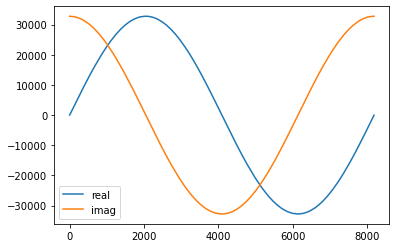

In [24]:
components = get_components(res_data)
plt.plot(list(range(N)), components['real'], label='real')
plt.plot(list(range(N)), components['imag'], label='imag')
plt.legend()